In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds

class QKDSystem2Decoy:
    def __init__(self, mu, nu1, nu2, L, e_detector=0.033, Y0=1.7e-6, eta_bob=0.045, e_0=0.5, alpha=0.21, N=5):
        self.mu = mu
        self.nu1 = nu1
        self.nu2 = nu2
        self.L = L

        self.e_detector = e_detector
        self.Y0 = Y0
        self.eta_bob = eta_bob
        self.e_0 = e_0
        self.alpha = alpha
        self.N = N
        

        self.eta = 10 ** (-self.alpha * self.L / 10) * self.eta_bob

    def H2(self, e1):
        return -e1 * np.log2(e1) - (1 - e1) * np.log2(1 - e1)

    def func(self, vars):
        Y1 = vars[0]
        e1 = vars[self.N]
        return Y1 * (1 - self.H2(e1))
    
    def constraint1(self, vars):
        Y = vars[:self.N]
        e = vars[self.N:]
        term = self.Y0 * np.exp(-self.mu) + np.exp(-self.eta * self.mu) - 1 + self.Y0
        
        for i in range(self.N):
            term += Y[i] * np.exp(-self.eta * self.mu) * self.mu ** (i+1) / np.math.factorial(i + 1)

        return term
    
    def constraint2(self, vars):
        Y = vars[:self.N]
        e = vars[self.N:]
        term = self.Y0 * np.exp(-self.nu1) + np.exp(-self.eta * self.nu1) - 1 + self.Y0
        
        for i in range(self.N):
            term += Y[i] * np.exp(-self.eta * self.nu1) * self.nu1 ** (i+1) / np.math.factorial(i + 1)

        return term
    
    def constraint3(self, vars):
        Y = vars[:self.N]
        e = vars[self.N:]
        term = self.Y0 * np.exp(-self.nu1) + np.exp(-self.eta * self.nu1) - 1 + self.Y0
        
        for i in range(self.N):
            term += Y[i] * np.exp(-self.eta * self.nu1) * self.nu1 ** (i+1) / np.math.factorial(i + 1)

        return term

    def constraint4(self, vars):
        Y = vars[:self.N]
        e = vars[self.N:]
        term = self.e_0 * self.Y0 * np.exp(-self.mu) - self.e_detector * (1 - np.exp(-self.eta * self.mu)) - self.e_0*self.Y0
        
        for i in range(self.N):
            term += e[i] * Y[i] * np.exp(-self.eta * self.mu) * self.mu ** (i+1) / np.math.factorial(i + 1)

        return term
    
    def constraint5(self, vars):
        Y = vars[:self.N]
        e = vars[self.N:]
        term = self.e_0 * self.Y0 * np.exp(-self.nu1) - self.e_detector * (1 - np.exp(-self.eta * self.nu1)) - self.e_0*self.Y0
        
        for i in range(self.N):
            term += e[i] * Y[i] * np.exp(-self.eta * self.nu1) * self.nu1 ** (i+1) / np.math.factorial(i + 1)

        return term
    
    def constraint6(self, vars):
        Y = vars[:self.N]
        e = vars[self.N:]
        term = self.e_0 * self.Y0 * np.exp(-self.nu2) - self.e_detector * (1 - np.exp(-self.eta * self.nu2)) - self.e_0*self.Y0
        
        for i in range(self.N):
            term += e[i] * Y[i] * np.exp(-self.eta * self.nu2) * self.nu2 ** (i+1) / np.math.factorial(i + 1)

        return term

    def non_linear_optimize(self):
        g1 = NonlinearConstraint(self.constraint1, lb = 0, ub = 0)
        g2 = NonlinearConstraint(self.constraint2, lb = 0, ub = 0)
        g3 = NonlinearConstraint(self.constraint3, lb = 0, ub = 0)
        g4 = NonlinearConstraint(self.constraint4, lb = 0, ub = 0)
        g5 = NonlinearConstraint(self.constraint5, lb = 0, ub = 0)
        g6 = NonlinearConstraint(self.constraint6, lb = 0, ub = 0)
        bounds = Bounds([0]*2*self.N, [1]*2*self.N)

        initial_guess = np.array([0.01]*2*self.N, dtype=np.float64) # combine x and y into one array
        solution = minimize(self.func, initial_guess, constraints=[g1,g2,g3,g4,g5,g6], method='trust-constr', bounds=bounds)

        # Get Y1 and e1
        Y = solution.x[:self.N]
        e = solution.x[self.N:]

        return Y, e

    def compute_R(self):
        Y, e = self.non_linear_optimize()
        Y1 = Y[0]
        e1 = e[0]
        Q1 = Y1 * self.mu * np.exp(-self.mu)
        Q_mu = self.Y0 + 1 - np.exp(-self.eta * self.mu)
        return -Q_mu * 1 * self.H2(self.e_detector) + Q1 * (1 - self.H2(e1))

    def get_R_vs_mu(self, mu_list, nu1, nu2, L):
        R_list = [self.compute_R(mu, nu1, nu2, L) for mu in mu_list]

        return R_list

In [ ]:
qkd_system_2_decoy = QKDSystem2Decoy(N=5)

mu_list = np.linspace(0, 1, 10)
nu1 = 0.05
nu2 = 0
L = 160
R_list = qkd_system_2_decoy.get_R_vs_mu(mu_list, nu1, nu2, L)

plt.plot(mu_list, R_list)
plt.xlabel("mu")
plt.ylabel("R")

# Get the optimal value of mu
mu_opt = mu_list[np.argmax(R_list)]


c:\Users\QiLin Xue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
c:\Users\QiLin Xue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


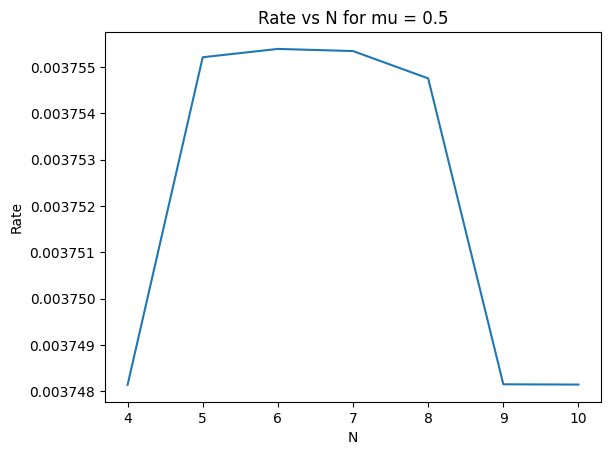

In [74]:
nu1 = 0.05
nu2 = 0

# test = QKDSystem2Decoy(mu=0.5, nu1=nu1, nu2=nu2, L=L, N=5)

def get_rate(mu, N, L=10):
    test_system = QKDSystem2Decoy(mu=mu, nu1=nu1, nu2=nu2, L=L, N=N)
    return test_system.compute_R()

# Plot the rate for N=4 to N=10 for mu = 0.5
N_list = [4,5,6,7,8,9,10]
R_list = [get_rate(0.5, N) for N in N_list]

plt.plot(N_list, R_list)
plt.xlabel("N")
plt.ylabel("Rate")
plt.title("Rate vs N for mu = 0.5")
plt.show()

C:\Users\QiLin Xue\AppData\Local\Temp\ipykernel_656\3215149832.py:26: RuntimeWarning: invalid value encountered in log2
  return -e1 * np.log2(e1) - (1 - e1) * np.log2(1 - e1)


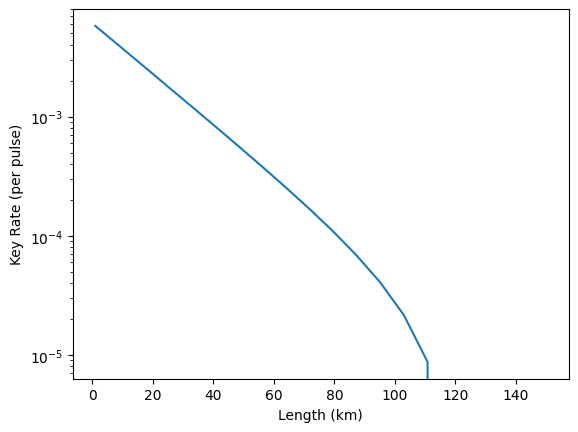

In [79]:
nu1 = 0.05
nu2 = 0

def get_R_from_L(L):
    test_system = QKDSystem2Decoy(mu=0.48, nu1=nu1, nu2=nu2, L=L, N=5)
    return test_system.compute_R()

# Plot rate vs distance
L = np.linspace(1, 150, 20)
R_list_2_decoy = [get_R_from_L(l) for l in L]

plt.plot(L, R_list_2_decoy)
plt.xlabel("Length (km)")
plt.ylabel("Key Rate (per pulse)")
plt.yscale('log')

# Save plot in HD
plt.savefig("decoy2.png", dpi=300)

c:\Users\QiLin Xue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
c:\Users\QiLin Xue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


L =  1.0 mu =  0.3
L =  1.0 mu =  0.3157894736842105
L =  1.0 mu =  0.33157894736842103
L =  1.0 mu =  0.34736842105263155
L =  1.0 mu =  0.3631578947368421
L =  1.0 mu =  0.3789473684210526
L =  1.0 mu =  0.39473684210526316
L =  1.0 mu =  0.4105263157894737
L =  1.0 mu =  0.4263157894736842
L =  1.0 mu =  0.4421052631578947
L =  1.0 mu =  0.45789473684210524
L =  1.0 mu =  0.4736842105263158
L =  1.0 mu =  0.4894736842105263
L =  1.0 mu =  0.5052631578947369
L =  1.0 mu =  0.5210526315789474
L =  1.0 mu =  0.5368421052631579
L =  1.0 mu =  0.5526315789473684
L =  1.0 mu =  0.5684210526315789
L =  1.0 mu =  0.5842105263157895
L =  1.0 mu =  0.6
===================================== Progress:  0.0
L =  17.555555555555557 mu =  0.3
L =  17.555555555555557 mu =  0.3157894736842105
L =  17.555555555555557 mu =  0.33157894736842103
L =  17.555555555555557 mu =  0.34736842105263155
L =  17.555555555555557 mu =  0.3631578947368421
L =  17.555555555555557 mu =  0.3789473684210526
L =  17.5555

C:\Users\QiLin Xue\AppData\Local\Temp\ipykernel_656\3215149832.py:26: RuntimeWarning: invalid value encountered in log2
  return -e1 * np.log2(e1) - (1 - e1) * np.log2(1 - e1)


L =  150.0 mu =  0.3
L =  150.0 mu =  0.3157894736842105
L =  150.0 mu =  0.33157894736842103
L =  150.0 mu =  0.34736842105263155
L =  150.0 mu =  0.3631578947368421
L =  150.0 mu =  0.3789473684210526
L =  150.0 mu =  0.39473684210526316
L =  150.0 mu =  0.4105263157894737
L =  150.0 mu =  0.4263157894736842
L =  150.0 mu =  0.4421052631578947
L =  150.0 mu =  0.45789473684210524
L =  150.0 mu =  0.4736842105263158
L =  150.0 mu =  0.4894736842105263
L =  150.0 mu =  0.5052631578947369
L =  150.0 mu =  0.5210526315789474
L =  150.0 mu =  0.5368421052631579
L =  150.0 mu =  0.5526315789473684
L =  150.0 mu =  0.5684210526315789
L =  150.0 mu =  0.5842105263157895
L =  150.0 mu =  0.6
===================================== Progress:  0.9


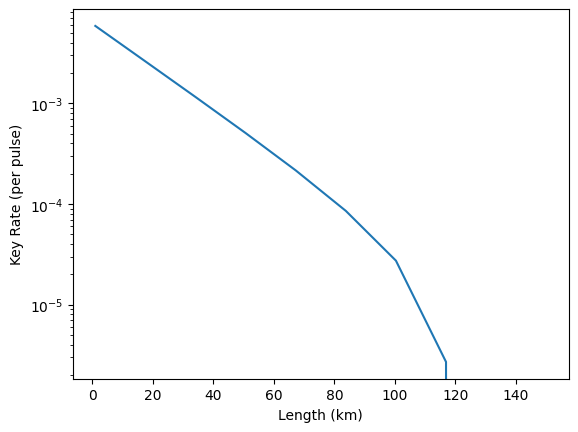

In [87]:
nu1 = 0.05
nu2 = 0

def get_R_from_L(mu, L):
    test_system = QKDSystem2Decoy(mu=mu, nu1=nu1, nu2=nu2, L=L, N=5)
    return test_system.compute_R()

def get_opt_mu_from_L(L):
    mu_list = np.linspace(0.3, 0.6, 20)
    R_list = []

    for mu in mu_list:
        R_list.append(get_R_from_L(mu, L))
        print("L = ", L, "mu = ", mu)

    return mu_list[np.argmax(R_list)]

def get_opt_R_from_L(L):
    opt_mu = get_opt_mu_from_L(L)
    return get_R_from_L(opt_mu, L)

# Plot rate vs distance
N_tot = 10
L = np.linspace(1, 150, N_tot)

R_list_2_decoy = []

for i in range(N_tot):
    R_list_2_decoy.append(get_opt_R_from_L(L[i]))
    print("===================================== Progress: ", i/N_tot)

plt.plot(L, R_list_2_decoy)
plt.xlabel("Length (km)")
plt.ylabel("Key Rate (per pulse)")
plt.yscale('log')

# Save plot in HD
plt.savefig("decoy2.png", dpi=300)

In [ ]:
test_system = QKDSystem2Decoy(mu=0.48, nu1=nu1, nu2=nu2, L=10, N=5)